### LLaVA 13B Inference from Replicate Server

### Pets Dataset

In [49]:
import os, time, base64
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from replicate.client import Client

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    
def gen_llava(img_path, prompt):
    with open(img_path, 'rb') as file:
        data = base64.b64encode(file.read()).decode('utf-8')
        image = f"data:image/jpeg;base64,{data}"

    RepClient = Client(api_token=os.environ.get("REPLICATE_API_TOKEN"))

    input = {
        "image": image,
        "prompt": prompt,
        "temperature": 0.1,
    }

    output = RepClient.run(
        "yorickvp/llava-13b:80537f9eead1a5bfa72d5ac6ea6414379be41d4d4f6679fd776e9535d1eb58bb",
        input=input
    )
    
    response = ("".join(output))
    return response

def create_df():
    columns = ['filename', 'label_id', 'init_pred', 'img_desc']
    return pd.DataFrame(columns=columns)

def all_classes():
    val_img_info_file = "../data/pets/test_stratified_subset_30.csv"
    label_map = pd.read_csv(val_img_info_file)
    all_labels = label_map['name'].unique().tolist()
    all_labels = set(all_labels)
    return all_labels

def main():
    img_path = '../database/Pets/images/'

    val_img_info_file = "../data/pets/test_stratified_subset_5.csv"
    working_file = "../data/pets/img_features.parquet"

    classes = all_classes()

    prompt_img_desc = "What do you see? Describe any object precisely, including its type or class."
    prompt_img_clf = "You are given an image and a list of class labels. Classify the image given the class labels. Answer using a single word if possible. Only choose word in class list. Here are the class labels: {}".format(classes)

    # Check if file exists
    try:
        img_features_df = pd.read_parquet(working_file)
        print("Loaded parquet!")
    except:
        print("Creating dataframe...")
        img_features_df = create_df()

        # Load label map
        val_data = pd.read_csv(val_img_info_file)
        img_features_df['filename'] = val_data['image']
        img_features_df['label_id'] = val_data['name']
        print("Created dataframe!")
        img_features_df.to_parquet(working_file)
        print("Saved parquet!")
    
    # Check worked labels
    for i in range(len(img_features_df)):
        start = time.time()
        print(f'{i+1}/{len(img_features_df)}')
        if img_features_df['img_desc'][i] is not None or pd.notna(img_features_df.loc[i, 'img_desc']):
            print(f"{img_features_df['filename'][i]} done!")
        else:
            image_path = os.path.join(img_path, f"{img_features_df['filename'][i]}.jpg")
            img_features_df.loc[i, 'init_pred'] = gen_llava(
                                                            image_path,
                                                            prompt_img_clf)
            img_features_df.loc[i, 'img_desc'] = gen_llava(
                                                            image_path,
                                                            prompt_img_desc)
        
            # Save working file
            img_features_df.to_parquet(working_file)
            end = time.time()
            print(f"Time taken per label: {round(end - start, 2)} seconds")
            print("-"*50)

In [63]:
main()

Loaded parquet!
1/185
Abyssinian_1 done!
2/185
Abyssinian_94 done!
3/185
Abyssinian_106 done!
4/185
Abyssinian_57 done!
5/185
Abyssinian_6 done!
6/185
Bengal_13 done!
7/185
Bengal_94 done!
8/185
Bengal_50 done!
9/185
Bengal_180 done!
10/185
Bengal_192 done!
11/185
Birman_13 done!
12/185
Birman_94 done!
13/185
Birman_50 done!
14/185
Birman_180 done!
15/185
Birman_191 done!
16/185
Bombay_104 done!
17/185
Bombay_3 done!
18/185
Bombay_25 done!
19/185
Bombay_24 done!
20/185
Bombay_59 done!
21/185
Time taken per label: 5.18 seconds
--------------------------------------------------
22/185
Time taken per label: 4.76 seconds
--------------------------------------------------
23/185
Time taken per label: 3.98 seconds
--------------------------------------------------
24/185
Time taken per label: 4.4 seconds
--------------------------------------------------
25/185
Time taken per label: 5.03 seconds
--------------------------------------------------
26/185
Time taken per label: 4.44 seconds
----

In [64]:
working_file = "../data/pets/img_features.parquet"
img_features_df = pd.read_parquet(working_file)
print(len(img_features_df))
img_features_df.tail(20)

185


filename                    label_id  \
165                   shiba_inu_140                   shiba inu   
166                    shiba_inu_94                   shiba inu   
167                    shiba_inu_50                   shiba inu   
168                   shiba_inu_189                   shiba inu   
169                     shiba_inu_1                   shiba inu   
170    staffordshire_bull_terrier_1  staffordshire bull terrier   
171   staffordshire_bull_terrier_12  staffordshire bull terrier   
172   staffordshire_bull_terrier_56  staffordshire bull terrier   
173  staffordshire_bull_terrier_104  staffordshire bull terrier   
174   staffordshire_bull_terrier_30  staffordshire bull terrier   
175              wheaten_terrier_13             wheaten terrier   
176              wheaten_terrier_94             wheaten terrier   
177              wheaten_terrier_50             wheaten terrier   
178             wheaten_terrier_180             wheaten terrier   
179             wheaten_terrier_191             wheaten terrier   
180            yorkshire_terrier_13           yorkshire terrier   
181            yorkshire_terrier_94           yorkshire terrier   
182            yorkshire_terrier_50           yorkshire terrier   
183           yorkshire_terrier_180           yorkshire terrier   
184           yorkshire_terrier_191           yorkshire terrier   

             init_pred                                           img_desc  
165          Shiba inu  The image features a small brown dog with a pi...  
166          Shiba inu  The image features a small brown dog lying on ...  
167          Shiba inu  The image features a small, brown dog sitting ...  
168          Shiba inu  In the image, there is a small brown dog stand...  
169          Shiba inu  The image features a small brown dog standing ...  
170            Bulldog  The image features a dog lying on the grass, h...  
171   American bulldog  The image features a brown and white dog with ...  
172   American bulldog  The image features a black dog standing in a f...  
173   American bulldog  In the image, there is a large brown dog sitti...  
174   American bulldog  In the image, there is a black dog standing on...  
175   Scottish terrier  The image features a large, shaggy dog with a ...  
176    Wheaten terrier  The image features a brown dog with a shaggy c...  
177   Scottish terrier  The image features a large, shaggy dog sitting...  
178    Wheaten terrier  The image features a man sitting on the floor ...  
179    Wheaten terrier  The image features a large, shaggy dog lying o...  
180   Scottish terrier  The image features a small brown dog standing ...  
181   Scottish terrier  The image features a small dog, possibly a ter...  
182  Yorkshire terrier  The image features a small dog sitting on a bl...  
183    Wheaten terrier  The image features a small brown and black dog...  
184   Scottish terrier  The image features a small, fluffy dog sitting...

In [66]:
img_features_df['init_pred'].unique()

array(['abyssinian', 'wheaten terrier', 'scottish terrier', 'siamese',
       'maine coon', 'ragdoll', 'russian blue', 'sphynx', 'hairless cat',
       'hairless', 'bulldog', 'american bulldog', 'hound', 'beagle',
       'english cocker spaniel', 'chihuahua', 'cocker spaniel', 'lab',
       'great pyrenees', 'shiba inu', 'samoyed', 'newfoundland',
       'pomeranian', 'pug', 'saint bernard', 'yorkshire terrier'],
      dtype=object)

In [65]:
# Accuracy
img_features_df['init_pred'] = img_features_df['init_pred'].str.lower()
img_features_df['label_id'] = img_features_df['label_id'].str.lower()

count = 0
for i in range(len(img_features_df)):
    if img_features_df['init_pred'][i] == img_features_df['label_id'][i]:
        count += 1

print(count/len(img_features_df))

0.2756756756756757


In [61]:
# Display Image 
from PIL import Image
import matplotlib.pyplot as plt
from pprint import pprint
def display_image(id):
    pprint(f"Description: {img_features_df['img_desc'][id]}")
    print("Initial Prediction: ", img_features_df['init_pred'][id])
    print("True Label: ", img_features_df['label_id'][id])
    img_path = '../database/Pets/images/'
    image_path = os.path.join(img_path, f"{img_features_df['filename'][id]}.jpg")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("="*50)

('Description: The image features a brown and white cat sitting on a couch. '
 'The cat is looking directly at the camera, appearing alert and curious. The '
 'couch is covered with a green fabric, providing a comfortable and cozy '
 'environment for the cat to relax.')
Initial Prediction:  Abyssinian
True Label:  Abyssinian


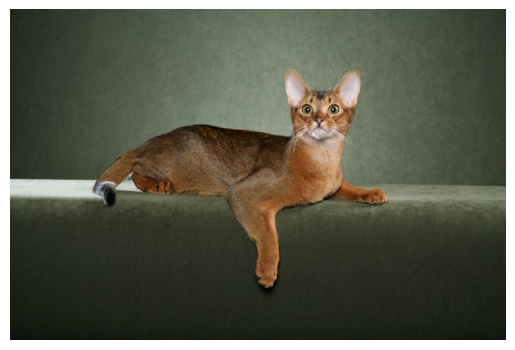

('Description: The image features a man wearing glasses and a hat, with a cat '
 'standing on his shoulder. The cat appears to be looking at the camera, while '
 'the man is looking at the cat. The scene takes place in front of a window, '
 'with a potted plant visible in the background.')
Initial Prediction:  Wheaten terrier
True Label:  Abyssinian


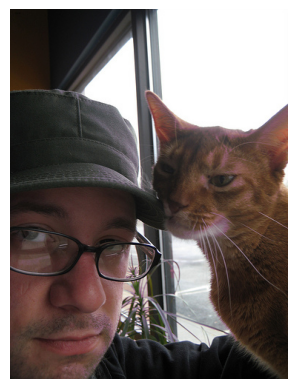

('Description: The image features a brown and black cat lying on a red '
 'surface, which could be a blanket or a piece of fabric. The cat appears to '
 'be relaxed and comfortable, possibly sleeping or resting. The red surface '
 'provides a contrasting background for the cat, making it the focal point of '
 'the scene.')
Initial Prediction:  Abyssinian
True Label:  Abyssinian


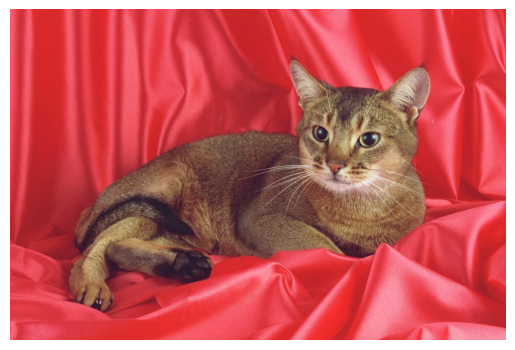

('Description: The image features a brown and white cat sitting on a table. '
 'The cat is looking at the camera with its eyes wide open, appearing curious '
 'or attentive. The cat is positioned in the center of the image, occupying a '
 'significant portion of the frame.')
Initial Prediction:  Wheaten terrier
True Label:  Abyssinian


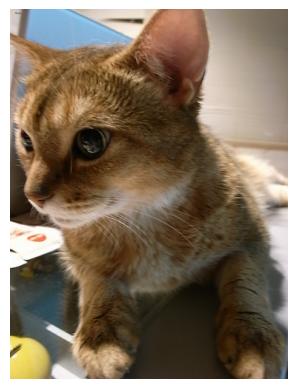

('Description: The image features a Siamese cat sitting on a couch. The cat is '
 'looking directly at the camera, with its eyes wide open, giving a close-up '
 'view of its face. The cat appears to be relaxed and comfortable on the '
 'couch, possibly enjoying some leisure time.')
Initial Prediction:  Abyssinian
True Label:  Abyssinian


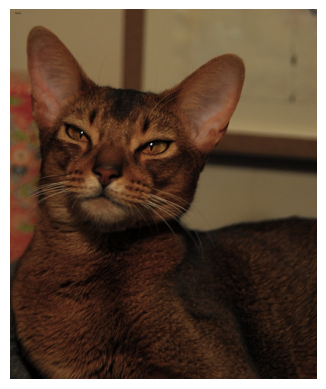

('Description: The image features a brown and black cat with a long tail, '
 'running across a lush green field. The cat appears to be enjoying its time '
 'outdoors, possibly hunting or exploring the area. The field is covered with '
 'grass, providing a natural and open environment for the cat to roam freely.')
Initial Prediction:  Abyssinian
True Label:  Bengal


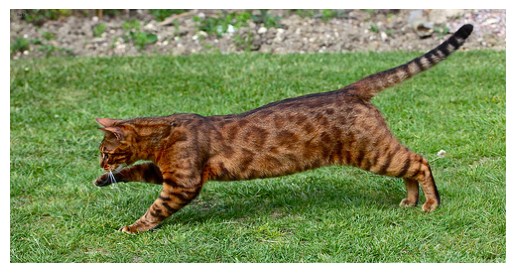

('Description: The image features a brown and black cat lying on a white '
 'surface, possibly a counter or a table. The cat appears to be relaxed and '
 'comfortable in its environment.')
Initial Prediction:  Abyssinian
True Label:  Bengal


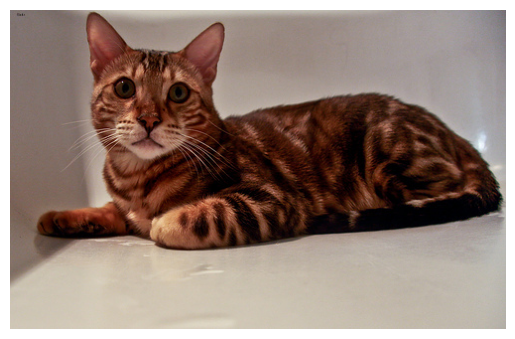

('Description: The image features a brown and black cat sitting on a counter. '
 'The cat appears to be looking at the camera with its mouth open, possibly '
 'making a funny face. The cat is positioned near a sink, which is located on '
 'the left side of the counter.')
Initial Prediction:  Wheaten terrier
True Label:  Bengal


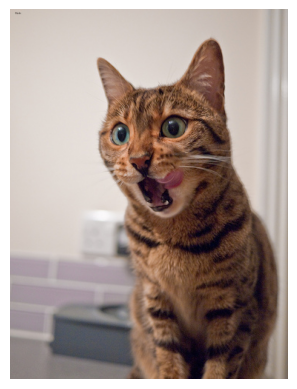

('Description: The image features a cat sitting on top of a pillow, which is '
 'placed on a couch. The cat appears to be looking at the camera, possibly '
 'posing for a picture. The couch is located near a window, allowing natural '
 'light to enter the room. The cat is the main subject of the image, and it is '
 'comfortably resting on the pillow.')
Initial Prediction:  Scottish terrier
True Label:  Bengal


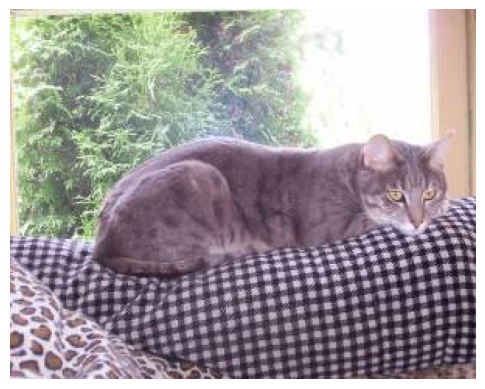

('Description: The image features a large, long-haired cat with a distinctive '
 'leopard-like pattern on its fur. The cat is walking near a body of water, '
 'possibly a lake, and appears to be staring at something in the distance. The '
 "cat's tail is visible, adding to the overall visual appeal of the scene.")
Initial Prediction:  Abyssinian
True Label:  Bengal


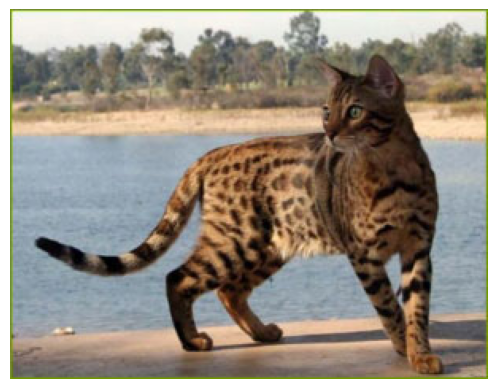

('Description: The image features a white and brown cat sitting on a couch. '
 'The cat is positioned in the center of the scene, with its head turned to '
 'the side. The couch is covered with a blue blanket, which provides a '
 'contrasting background for the cat. The cat appears to be relaxed and '
 'comfortable in its environment.')
Initial Prediction:  Scottish terrier
True Label:  Birman


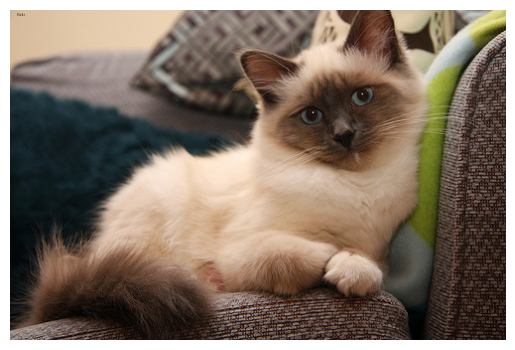

('Description: The image features a large, fluffy cat with a blue collar lying '
 'on a wooden floor. The cat appears to be relaxed and comfortable in its '
 'environment.')
Initial Prediction:  Scottish terrier
True Label:  Birman


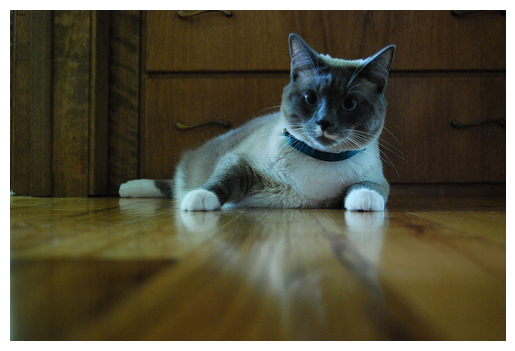

('Description: The image features a Siamese cat sitting on a red couch. The '
 'cat is looking at the camera, and it appears to be a young cat. The couch is '
 'located in the background, and the cat is sitting on top of it.')
Initial Prediction:  Siamese
True Label:  Birman


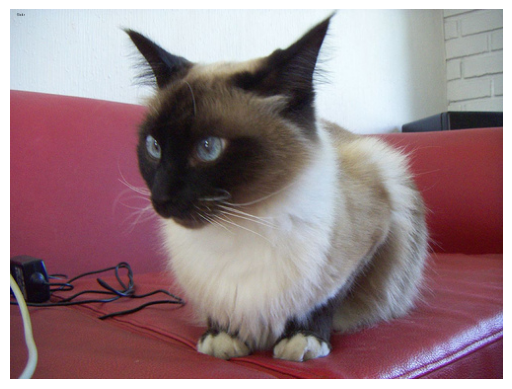

('Description: The image features a brown and white cat walking across a '
 'wooden floor. The cat appears to be in a living room, as there is a chair '
 'and a dining table in the background. The cat is walking on a hardwood '
 'floor, which is a common type of flooring material.')
Initial Prediction:  Scottish terrier
True Label:  Birman


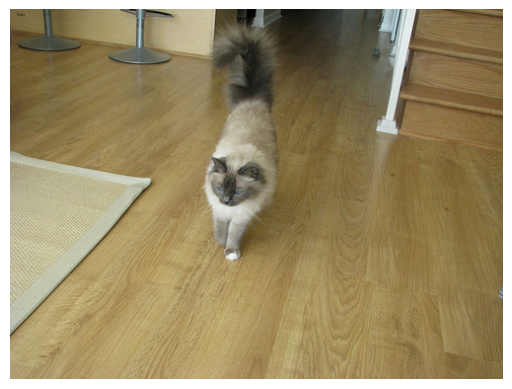

('Description: The image features a large, fluffy cat with blue eyes sitting '
 'on a table. The cat is positioned in the center of the scene, occupying a '
 'significant portion of the image. The table appears to be a dining table, '
 'and there are several books scattered around it. Some books are placed near '
 'the cat, while others are located at the edges of the table. The scene gives '
 'off a cozy and relaxed atmosphere, with the cat seemingly enjoying its time '
 'on the table.')
Initial Prediction:  Abyssinian
True Label:  Birman


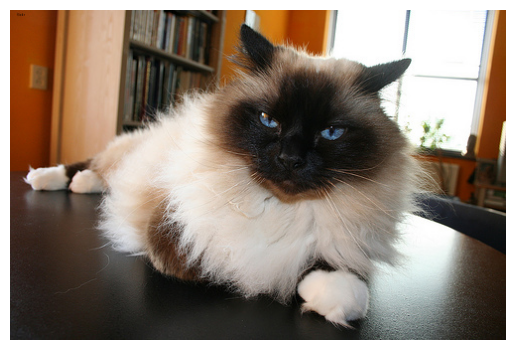

('Description: The image features a black cat sitting on top of a white wall. '
 "The cat is looking up, possibly observing something or someone. The cat's "
 'position on the wall is quite unusual, as it is not a typical place for a '
 'cat to sit or rest.')
Initial Prediction:  Maine coon
True Label:  Bombay


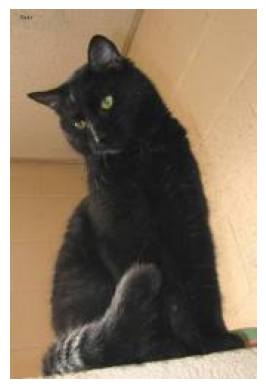

('Description: The image features a black cat standing on a white background. '
 'The cat appears to be walking or running, with its body facing the camera. '
 "The cat's eyes are wide open, and it has a focused expression. The cat's fur "
 'is shiny, and it seems to be the main subject of the image.')
Initial Prediction:  Abyssinian
True Label:  Bombay


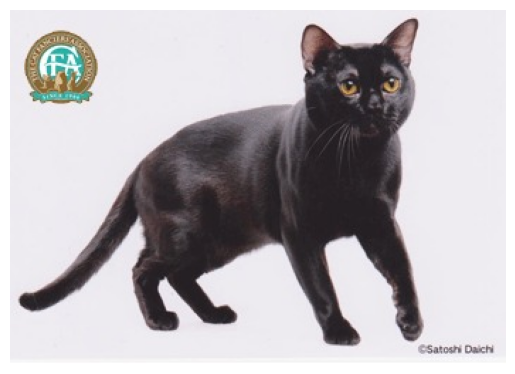

('Description: In the image, there is a black cat lying on the floor next to a '
 'pink and green ball. The cat appears to be looking at the camera, while the '
 'ball is placed nearby, possibly for the cat to play with.')
Initial Prediction:  Ragdoll
True Label:  Bombay


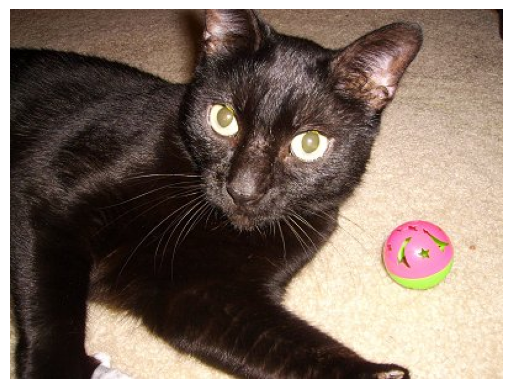

('Description: The image features a black cat standing on a white background. '
 'The cat is looking directly at the camera, with its green eyes capturing '
 "attention. The cat's tail is visible, extending from the left side of the "
 'image towards the top. The cat appears to be the main subject of the photo, '
 'with the white background providing a clean and simple backdrop.')
Initial Prediction:  Abyssinian
True Label:  Bombay


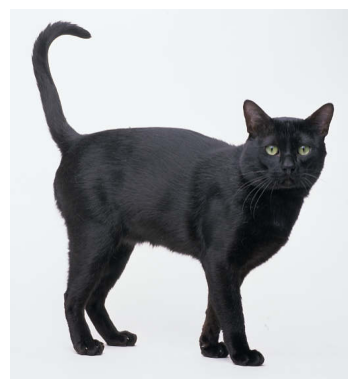

('Description: The image features a close-up of a black cat with yellow eyes. '
 "The cat's eyes are wide open, and it appears to be looking directly at the "
 "camera. The cat's fur is black, and its eyes are a striking yellow color. "
 "The cat's face is the main focus of the image, with the rest of its body not "
 'visible.')
Initial Prediction:  Russian blue
True Label:  Bombay


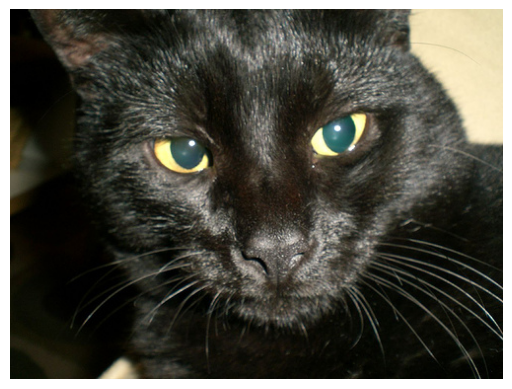

In [62]:
for i in range(20):
    display_image(i)